In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import missingno as msno
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import and read data as pandas dataframe.
# The data is already divided into a training and test set. The other participants in the competition used this distribution.
# In orde to compare our resolt we keep the same test and training set.
gender_survived = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


First step is to look at the data to see which columns contain valuable information and which can be removed. Furthermore, I will look at the different categories to see if there are missing or strange values.

setlist Survived [0, 1]
setlist Pclass [1, 2, 3]
setlist sex ['male', 'female']

There are 177 people in the training set of whom the age is not known.
Possible solution: replace nan with average age, guess age based on other data, remove rows, or guess from distribution.

setlist SibSp [0, 1, 2, 3, 4, 5, 8]
setlist Parch [0, 1, 2, 3, 4, 5, 6]
Number of different Ticket types 681

There are 15 people in the training set who did not pay for their ticket.
This could be outliers. Could remove the corresponding rows.

Number of different Cabin categories 148
The number of people whos cabin number is nan is 687

setlist Embarked ['S', nan, 'C', 'Q']
There are 2 people in the training set who embarked from nan.
Possible solution: make a guess, or remove rows.
Note that you must guess a value for Embarked, for people who also have nan in the test set.


<AxesSubplot:>

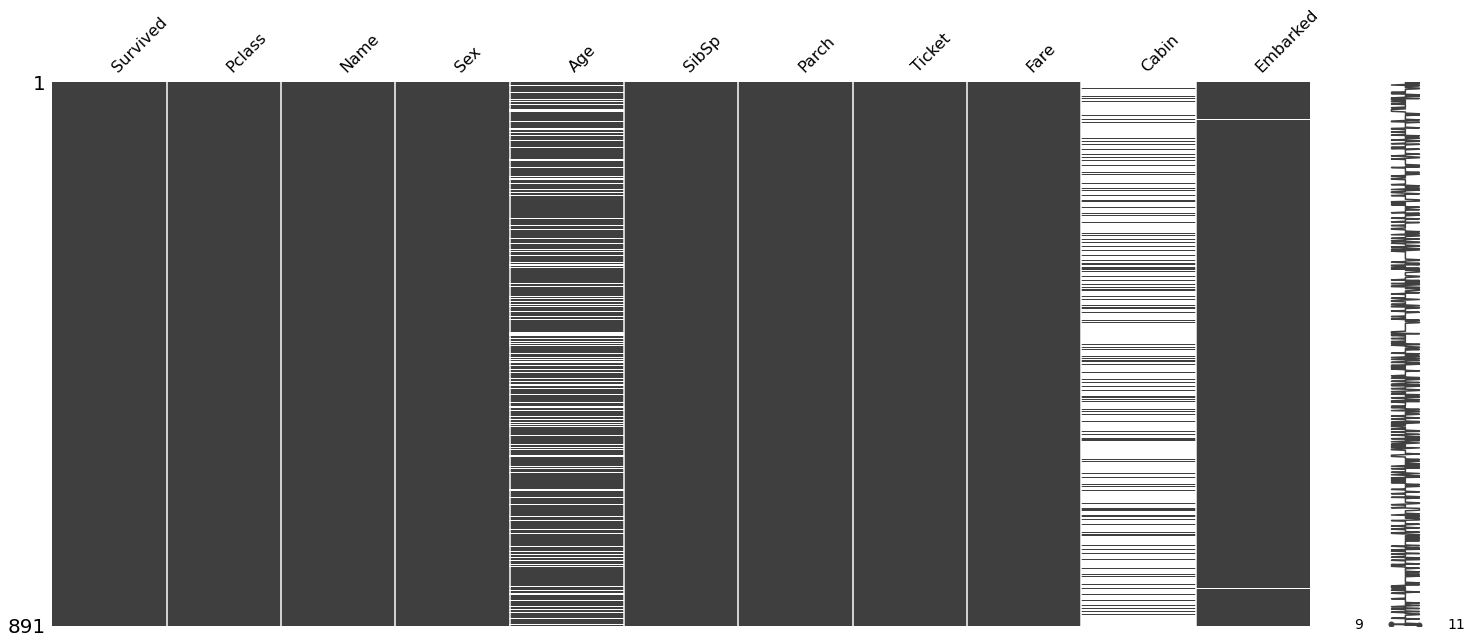

In [3]:
#Look at each column and their setlist. 

# PASSENGERID
# The Passengger ID has nothing to do with the individual and is added for computational reasons.
# For this reason the column 'PassengerId' is not used in the prediction models.
train = train.drop(columns=['PassengerId'])

# SURVIVED
# No strange values.
print('setlist Survived',list(set(train['Survived'])))

# PCLASS
# No strange values.
print('setlist Pclass',list(set(train['Pclass'])))

# NAME
# The names of the passengers are individuel and there is no relationship between them. 
# The family name could correlate with to survival chance, but there are unrelated people with the same last name.
# Furthermore, the number of family members is already recorded in 'SibSp' and 'Parch' same for the gender of a person. 
# For these reasons the column 'Name' shall not be used for the predictions models


# SEX
# No strange values.
print('setlist sex',list(set(train['Sex'])))
print()

# AGE
counter = train.Age.isnull().values.sum()
print('There are',counter, 'people in the training set of whom the age is not known.')
print('Possible solution: replace nan with average age, guess age based on other data, remove rows, or guess from distribution.')
print()

# SIBSP
# No strange values.
print('setlist SibSp', list(set(train['SibSp'])))

# PARCH
# No strange values.
print('setlist Parch',list(set(train['Parch'])))

# TICKET
# No nan values
print('Number of different Ticket types',len(list(set(train['Ticket']))))
print()

# FARE
Fare = train['Fare']
counter = 0
for i in Fare:
    if i == 0 or i < 0:
        counter+=1
print('There are',counter,'people in the training set who did not pay for their ticket.')
print('This could be outliers. Could remove the corresponding rows.')
print()

# CABIN
print('Number of different Cabin categories',len(list(set(train['Cabin']))))
nan_cabins = train.Cabin.isnull().values.sum()
print('The number of people whos cabin number is nan is', nan_cabins)
print()

# EMBARKED
print('setlist Embarked',list(set(train['Embarked'])))
counter = train.Embarked.isnull().values.sum()
print('There are',counter, 'people in the training set who embarked from nan.')
print('Possible solution: make a guess, or remove rows.')
print('Note that you must guess a value for Embarked, for people who also have nan in the test set.')


msno.matrix(train)

<AxesSubplot:>

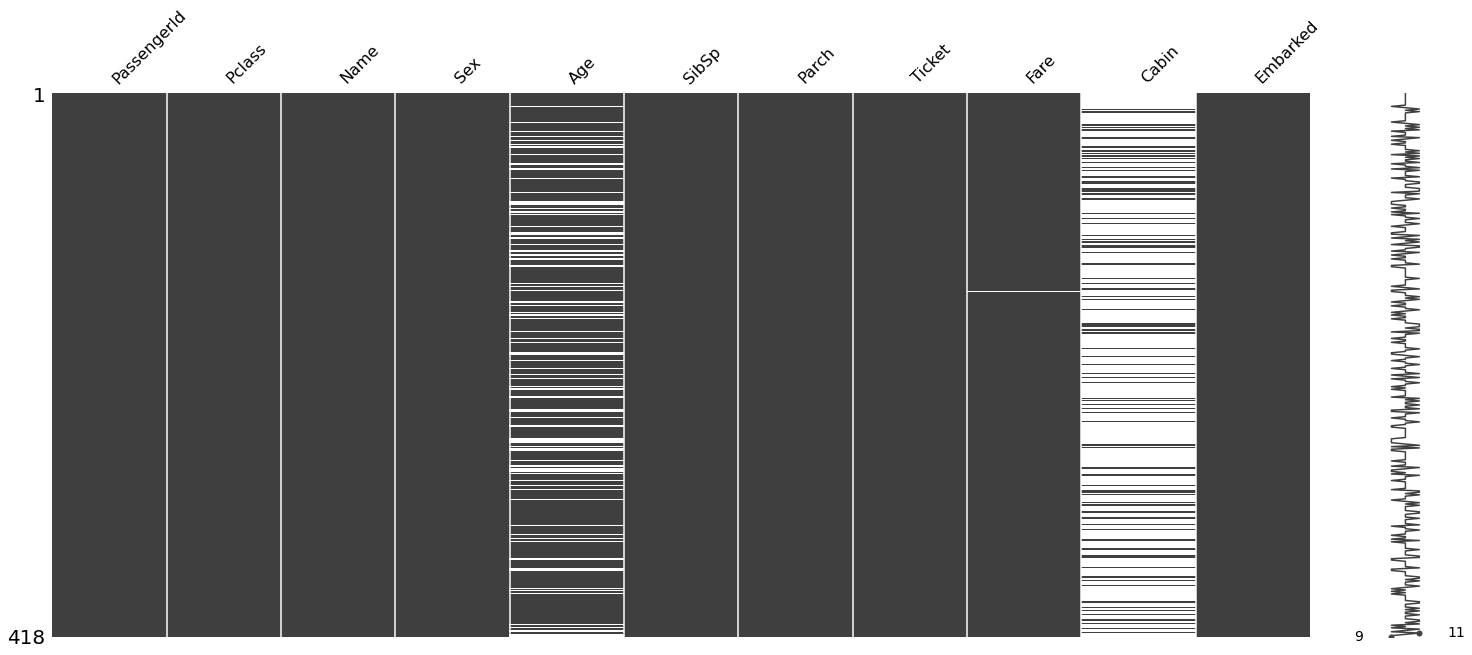

In [4]:
msno.matrix(test)

The column age needs some works since there are 177 missing values. Possible solutions are to remove the rows but 177 people are a significant part of the dataset and therefor this approah is undesired. Another option is to give the missing people the average age, but this is a very stiff approach. It is also possible to guess the age of each individual based on the distribution off the known ages. Another possibility is to use machine learning to predict the age.

The Ticket columns seems to have both integer and string descriptions. The string description seem to contain additional information before mentioning the nicket number. There are two options, either do nothing and leave it as it is, but this could be confusing since a ticket with a string before the ticket number could indicate the same ticket as a ticket without a string. Solution is to make two instances of the datset, one with the original ticket column and one where the string tickets are transformed to also only contain a integer.

The column Fare contains 15 people who did not pay for their ticket, these people are not babies. This means that they could be outliers or that they were given their ticket. Because we don't know what happend we leave these in the dataset.

The Cabin column has 687 missing values. This is the majority of the dataset. The cabin names are strings thus it is not an option to replace all the nan vlaues with an average. One could fill the missing values by pulling form the distribution or use machine learning to predict the cabin. 

The column Embarked contains two who embarked from nan.  This is notpossible and a solution is either to fill in the values or remove the rows. We choose to remove the two rows.

Furthermote, we can add a column named 'Family', which is a sum of yhe SibSb and Parch column. We can test if this column adds any accuracy. 

In [5]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# AGE 

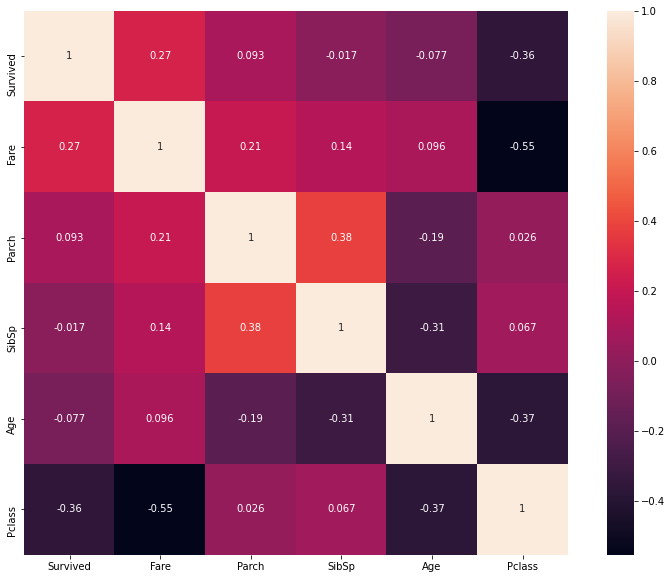

In [6]:
# AGE
pred_age = train.copy(deep=True)
pred_age = train.drop(columns=['Sex', 'Ticket', 'Cabin', 'Embarked'])
index_ageless = []
# Get all indices of agless people.
for row in range(len(pred_age)):
    if math.isnan(pred_age['Age'][row]):
        index_ageless.append(row)
pred_age = pred_age.drop(pred_age.index[index_ageless])
pred_age = pred_age.reset_index(drop=True)



# Produce correlation heatmap, to see which columns correlate with the age.
def make_corrmap(data):
    corrmat = data.corr()
    k = 20 #Number of variables for heat map with largest correlation.
    cols = corrmat.nlargest(k, 'Survived')['Survived'].index
    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(data[cols].corr(), vmax=1, square=True, annot=True);

make_corrmap(pred_age)

# Conclusion all available variables have correlation
# The variable Pclass is actually not suitable for multivariate regression beacuse it is a category.
# But the heatmap does show a high correlation and the model erforms better with it included.

In [7]:
# Make a linear regression model for the prediction of age.
reg = linear_model.LinearRegression()
reg.fit(pred_age[['Survived','Pclass','SibSp', 'Parch', 'Fare']],pred_age['Age'])

LinearRegression()

In [8]:
# Check if random guesser performs better.
correct = 0
sum_square_error_pred = 0

for i in range(len(pred_age)):
    true_age = pred_age['Age'][i]
    
    survived = train['Survived'][i]
    pclass = train['Pclass'][i]
    sibsp = train['SibSp'][i]
    parch = train['Parch'][i]
    fare = train['Fare'][i]
    pred = np.round(reg.predict([[survived, pclass, sibsp, parch, fare]]))
    
    sum_square_error_pred += (pred - true_age )**2
    
    if true_age - 3 <= pred <= true_age + 3:
        correct+=1

print("The mean squared error of the age predictor is", np.mean(sum_square_error_pred))
print('The age predictor is correct in', (correct/len(pred_age))*100, '% of the cases')

# Check if random guesser does not perform better 
correct = 0
sum_square_error_pred = 0
for i in range(len(pred_age)):
    true_age = pred_age['Age'][i]
    
    row = random.randint(0, len(pred_age)-1)
    
    guess = pred_age['Age'][row]
    sum_square_error_pred += (guess - true_age )**2
    if true_age-3 <= guess <= true_age+3:
        correct+=1

print("The mean squared error of the random guesser isis", np.mean(sum_square_error_pred))
print('the random age guesser is correct in', (correct/len(pred_age))*100, '% of the cases')

The mean squared error of the age predictor is 203484.95450000002
The age predictor is correct in 18.207282913165265 % of the cases
The mean squared error of the random guesser isis 310730.02869999997
the random age guesser is correct in 10.92436974789916 % of the cases


In [9]:
# the age prediction model has a better performance and a lower ean squared error.
# Meaning that it is better at predicting a passengers age, use this technnique to fill in missing values.
for i in index_ageless:
    survived = train['Survived'][i]
    pclass = train['Pclass'][i]
    sibsp = train['SibSp'][i]
    parch = train['Parch'][i]
    fare = train['Fare'][i]
    pred = np.round(reg.predict([[survived, pclass, sibsp, parch, fare]]))
    train.loc[i, 'Age'] = pred
train


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.0,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [11]:
# Also add all missing values in the test data set, but make model without survived variable

# Make a linear regression model for the prediction of age.
reg_test_age = linear_model.LinearRegression()
reg_test_age.fit(pred_age[['Pclass','SibSp', 'Parch', 'Fare']],pred_age['Age'])

index_ageless_test = []
# Get all indices of ageless people.
for row in range(len(test)):
    if math.isnan(test['Age'][row]):
        index_ageless_test.append(row)
        
for i in index_ageless_test:
    pclass = test['Pclass'][i]
    sibsp = test['SibSp'][i]
    parch = test['Parch'][i]
    fare = test['Fare'][i]
    pred= np.round(reg_test_age.predict([[pclass, sibsp, parch, fare]]))
    test.loc[i, 'Age'] = pred
    
# there are many people with an age which is .5

# Add Family column

In [12]:
# Add a column named 'Family', which is a sum of yhe SibSb and Parch column. 
# We can test if this column adds any accuracy. 
def add_family(data):    
    family_members = []
    for i in range(len(data)):
        fam = data['SibSp'][i] + data['Parch'][i]
        family_members.append(fam)
    data['Family'] = family_members
add_family(train)
add_family(test)


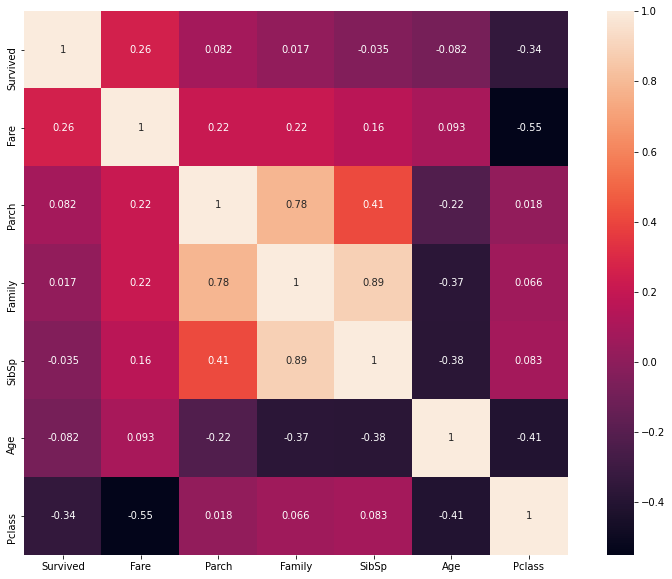

In [13]:
# Produce correlation heatmap, to see if Family has any correlation.
make_corrmap(train)

# TICKET

The Ticket columns seems to have 
- an optional string prefix TktPre 
- and a number TktNum number

In [14]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,23.0,1,2,W./C. 6607,23.4500,NaN,S,3
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [15]:
# Make a columns with only the ticket numbers.
cleaned_tickets = train['Ticket'].copy(deep = True)
for row in range(len(train)):
    ticket = cleaned_tickets[row]
    if isinstance(ticket, int):
        continue
    if ticket.isdigit():
        cleaned_tickets[row] = int(ticket)
    else:
        splitted = ticket.split()
        if splitted[-1].isdigit(): 
            cleaned_tickets.loc[row] = int(splitted[-1])

# Collect the indices of rows which are not integers.
to_be_removed_rows = []
for i in range(len(cleaned_tickets)):
    if not isinstance(cleaned_tickets[i], int):
        to_be_removed_rows.append(i)

In [16]:
# Add the column to the dataframe and remove the rows which do not have a ticket number.
train['Tickets_nr'] = cleaned_tickets
train = train.drop(train.index[to_be_removed_rows])
train = train.reset_index(drop=True)

# LAST NAMES 

In [17]:
# Make column with only last_names
names = train['Name'].copy(deep = True)
for row in range(len(train)):
    name = names[row]
    splitted = name.split()
    last_name = splitted[0]
    last_name = last_name[:-1]
    names.loc[row] = last_name

train['Last_names'] = names

In [18]:
# We can use the last name and ticket number column to find family members which are not directly related.
# People with the same or consecutive ticket numbers and same last name are likely family.

# make a dataframe and set all values to 0
cousins = train['Family'].copy(deep = True)
for i in range(len(cousins)):
    cousins.loc[i] = 0

# If another person has the same lastname and a neghbouring ticket (within a range of 10), then they are considered family
ticks = train['Tickets_nr']
for person in range(len(cousins)):
    family_members = 0
    ticket = ticks[person]
    last_name = names[person]
    for passenger in range(len(cousins)):
#         if you find the person itself, continue
        if passenger == person:
            continue
        if last_name == names[passenger] and ticket-10 <= ticks[person] <= ticket+10:
            family_members+=1
    cousins.loc[person] = family_members
    
#  Add column to dataframe
train['Cousins'] = cousins

# remove the name column since that does not contain any additional information:
train = train.drop(columns=['Name'])

In [19]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Tickets_nr,Last_names,Cousins
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,21171,Braund,1
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,17599,Cumings,0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3101282,Heikkinen,0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,113803,Futrelle,1
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,373450,Allen,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0,2,male,27.0,0,0,211536,13.0000,NaN,S,0,211536,Montvila,0
883,1,1,female,19.0,0,0,112053,30.0000,B42,S,0,112053,Graham,2
884,0,3,female,23.0,1,2,W./C. 6607,23.4500,NaN,S,3,6607,Johnston,1
885,1,1,male,26.0,0,0,111369,30.0000,C148,C,0,111369,Behr,0


# CABIN

I dont yet know what to do with this column

In [38]:
# Give all missing values teh same value
train.Cabin = train.Cabin.fillna('NA')
test.Cabin = test.Cabin.fillna('NA')

# EMBARKED

In [37]:
# There are two poeple from whom we do not knwo where they embarked
# WE give these people the most frequeently occuring value in the dataset.
train.Embarked.fillna(train.Embarked.mode()[0], inplace = True)

# make gender categories numerical

In [44]:
# to do: make sure male and female has the same code in the test set
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])

# Make embarked numerical

In [53]:
# to do: make sure male and female has the same code in the test set
train['Embarked'] = LabelEncoder().fit_transform(train['Embarked'])

In [52]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Tickets_nr,Last_names,Cousins
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NA,2,1,21171,Braund,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,0,1,17599,Cumings,0
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NA,2,0,3101282,Heikkinen,0
3,1,1,0,35.0,1,0,113803,53.1000,C123,2,1,113803,Futrelle,1
4,0,3,1,35.0,0,0,373450,8.0500,NA,2,0,373450,Allen,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0,2,1,27.0,0,0,211536,13.0000,NA,2,0,211536,Montvila,0
883,1,1,0,19.0,0,0,112053,30.0000,B42,2,0,112053,Graham,2
884,0,3,0,23.0,1,2,W./C. 6607,23.4500,NA,2,3,6607,Johnston,1
885,1,1,1,26.0,0,0,111369,30.0000,C148,0,0,111369,Behr,0


<AxesSubplot:>

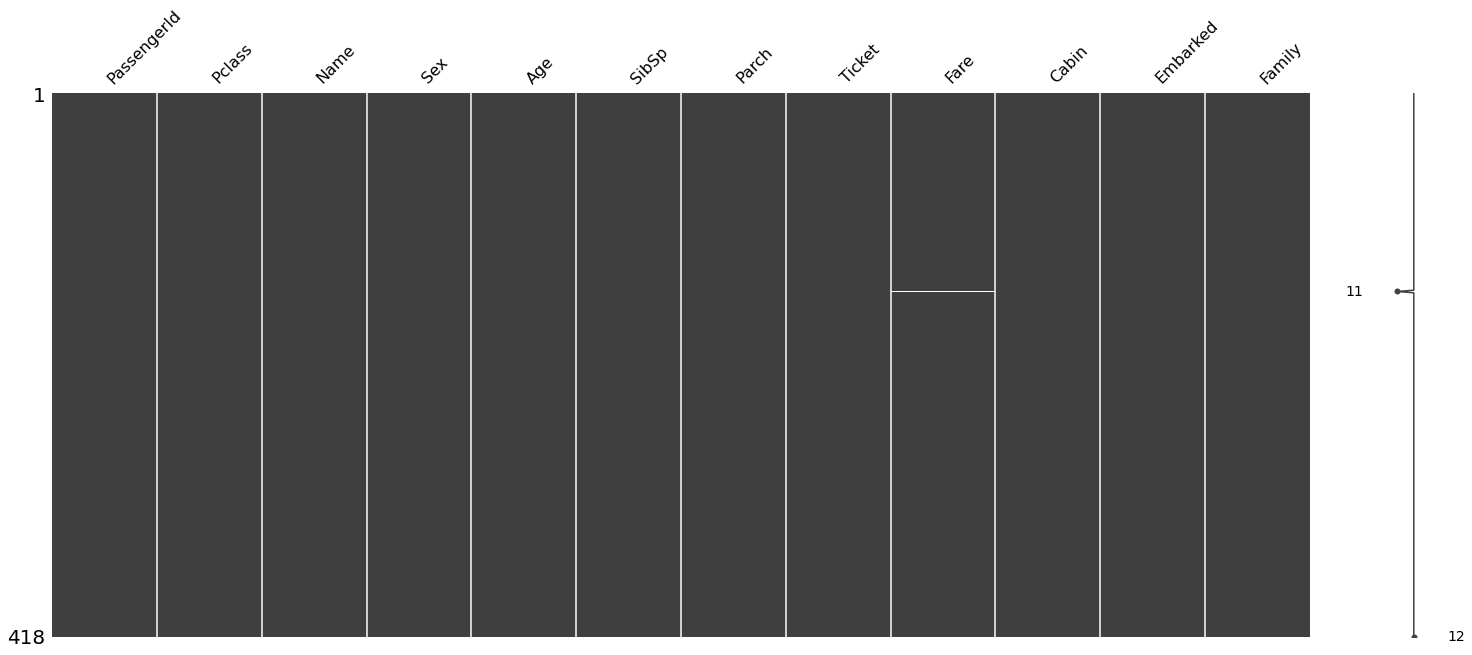

In [55]:
msno.matrix(test)

In [ ]:
# TO do order it correctly,, add something for the missing fare value. remove columns which are no longer interesting. Make visualisation. CHoose techniques

In [ ]:
Sur_Age = train.loc[train.Survived == 1]["Age"]
Dead_Age = train.loc[train.Survived == 0]["Age"]

plt.hist([Sur_Age, Dead_Age], bins = 50, histtype = 'barstacked', label = ['Survived', 'Died'])

plt.legend()
plt.show()

In [ ]:
Age_1 = train.loc[train.Pclass ==1]["Age"]
Age_2 = train.loc[train.Pclass ==2]["Age"]
Age_3 = train.loc[train.Pclass ==3]["Age"]

plt.hist([Age_1, Age_2, Age_3], bins = 20, histtype = 'step', label = ['1st class', '2nd class', '3rd class'])
plt.legend()
plt.title('The age per class')
plt.show()

Fare_1 = train.loc[train.Pclass ==1]["Fare"]
Fare_2 = train.loc[train.Pclass ==2]["Fare"]
Fare_3 = train.loc[train.Pclass ==3]["Fare"]

plt.hist([Fare_1, Fare_2, Fare_3], bins = 20, histtype = 'step', label = ['1st class', '2nd class', '3rd class'])
plt.legend()
plt.title('the class per ticket price')
plt.show()

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=train);

In [ ]:
def accuracy(predictions):
    correct = 0
    for i in range(len(gender_survived)):
        if predictions['Survived'][i] == gender_survived['Survived'][i]:
            correct += 1
    return((correct/len(gender_survived))* 100)
    
# make a random guesser as a base case

thousand_guesses_accurate = []   
for i in range(1000):
    guessed = gender_survived.copy()
    for i in range(len(test)):
        row = random.randint(0, len(train)-1)
        guess = train["Survived"][row]
        guessed['Survived'][i] = guess
    correct = accuracy(guessed)
    thousand_guesses_accurate.append(correct)
print('Average correct percentage guesser is ', np.mean(thousand_guesses_accurate),'%')